# Training Log Analysis
Questo notebook carica `training_log.csv` prodotto da `train.py` e mostra le curve di loss per train/val/test. Modifica il percorso in base alla run che vuoi ispezionare.

In [1]:
1+1

2

In [13]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

out_path = Path('../outputs/runs/exp_7_notempstride_hmupsample')
out_path = Path('../outputs/runs/exp_9_hm-upsample+conv_stride1')


#LOG_PATH = Path('../outputs/runs/exp7_temporalT3/training_log.csv')
LOG_PATH = out_path / Path('training_log.csv')
log_df = pd.read_csv(LOG_PATH)
#display(log_df)


# 

## Loss

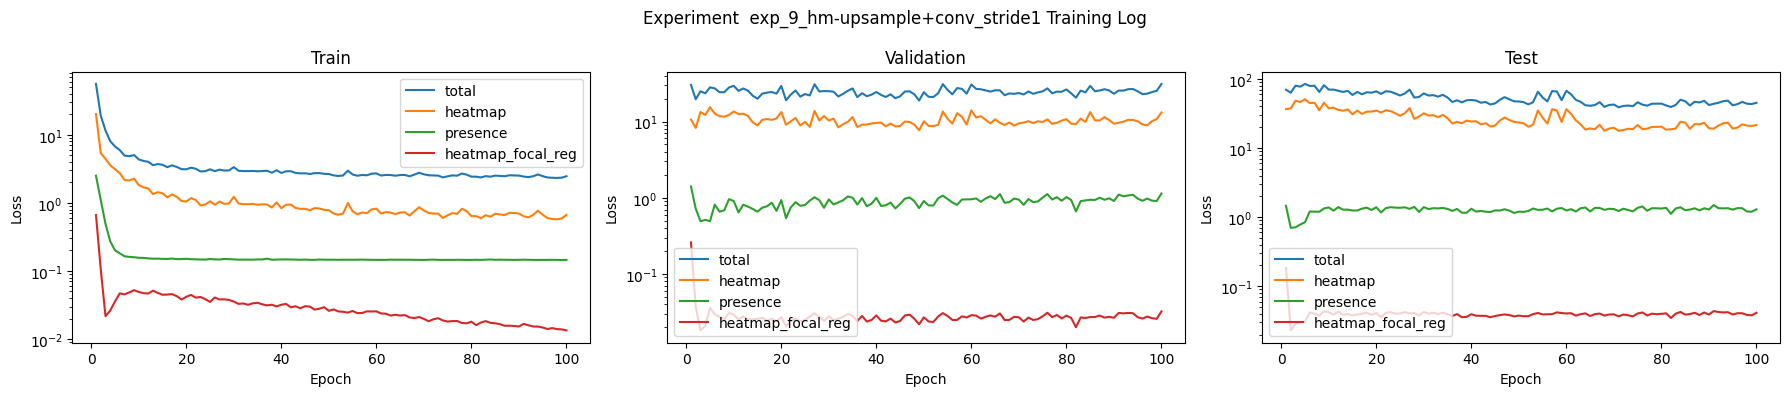

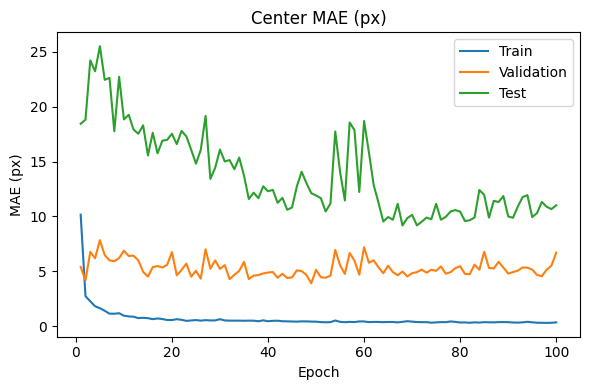

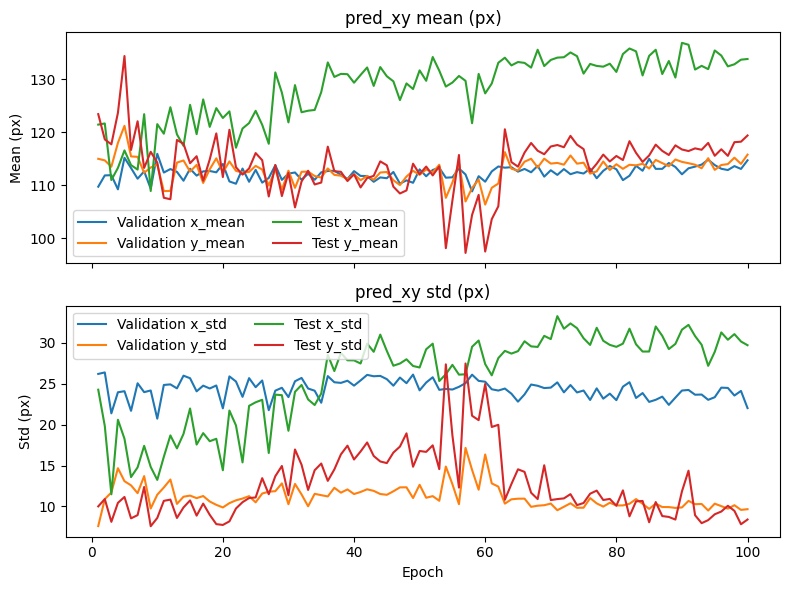

In [31]:

splits = {
    'Train': ('train_loss', 'train_heatmap_loss', 'train_presence_loss', 'train_heatmap_focal_reg'),
    'Validation': ('val_loss', 'val_heatmap_loss', 'val_presence_loss', 'val_heatmap_focal_reg'),
    'Test': ('test_loss', 'test_heatmap_loss', 'test_presence_loss', 'test_heatmap_focal_reg')
}

log_df = pd.read_csv(LOG_PATH)

fig, axes = plt.subplots(1, len(splits), figsize=(6 * len(splits), 4), sharex=True)
if not isinstance(axes, (list, tuple, np.ndarray)):
    axes = [axes]

for ax, (title, cols) in zip(axes, splits.items()):
    epochs = log_df['epoch']
    plotted = False
    labels = []
    for metric in cols:
        if 'heatmap_focal_reg' in metric:
            labels.append('heatmap_focal_reg')
        elif metric.endswith('heatmap_loss'):
            labels.append('heatmap')
        elif metric.endswith('presence_loss'):
            labels.append('presence')
        else:
            labels.append('total')
    for metric, label in zip(cols, labels):
        series = log_df[metric].bfill()
        if series.notna().any():
            ax.plot(epochs[:], series[:], label=label)
            plotted = True
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    if plotted:
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'N/A', transform=ax.transAxes, ha='center', va='center', fontsize=12)
    ax.set_yscale('log')

plt.suptitle('Experiment  {} Training Log'.format(LOG_PATH.parent.name))
plt.tight_layout()
plt.savefig(LOG_PATH.parent / 'training_log_plot.png')

# --- Center MAE (DSNT runs only) ---
mae_cols = {
    'Train': 'train_center_mae_px',
    'Validation': 'val_center_mae_px',
    'Test': 'test_center_mae_px',
}
available_mae = [k for k, c in mae_cols.items() if c in log_df.columns and log_df[c].notna().any()]
if available_mae:
    fig2, ax2 = plt.subplots(1, 1, figsize=(6, 4), sharex=True)
    epochs = log_df['epoch']
    for split_name in available_mae:
        c = mae_cols[split_name]
        series = log_df[c].bfill()
        if series.notna().any():
            ax2.plot(epochs, series, label=split_name)
    ax2.set_title('Center MAE (px)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE (px)')
    ax2.legend()
    plt.tight_layout()
    plt.savefig(LOG_PATH.parent / 'center_mae_plot.png')

# --- pred_xy stats (DSNT eval only) ---
pred_cols = {
    'Validation': {
        'x_mean': 'val_pred_x_mean_px',
        'x_var': 'val_pred_x_var_px',
        'y_mean': 'val_pred_y_mean_px',
        'y_var': 'val_pred_y_var_px',
    },
    'Test': {
        'x_mean': 'test_pred_x_mean_px',
        'x_var': 'test_pred_x_var_px',
        'y_mean': 'test_pred_y_mean_px',
        'y_var': 'test_pred_y_var_px',
    },
}
available_splits = []
for split_name, cols in pred_cols.items():
    if all(c in log_df.columns for c in cols.values()) and log_df[cols['x_mean']].notna().any():
        available_splits.append(split_name)

if available_splits:
    fig3, axes3 = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    epochs = log_df['epoch']
    for split_name in available_splits:
        cols = pred_cols[split_name]
        x_mean = log_df[cols['x_mean']].bfill()
        y_mean = log_df[cols['y_mean']].bfill()
        x_var = log_df[cols['x_var']].bfill()
        y_var = log_df[cols['y_var']].bfill()
        x_std = np.sqrt(np.maximum(x_var.to_numpy(dtype=float), 0.0))
        y_std = np.sqrt(np.maximum(y_var.to_numpy(dtype=float), 0.0))

        axes3[0].plot(epochs, x_mean, label=f'{split_name} x_mean')
        axes3[0].plot(epochs, y_mean, label=f'{split_name} y_mean')
        axes3[1].plot(epochs, x_std, label=f'{split_name} x_std')
        axes3[1].plot(epochs, y_std, label=f'{split_name} y_std')

    axes3[0].set_title('pred_xy mean (px)')
    axes3[0].set_ylabel('Mean (px)')
    axes3[0].legend(ncol=2)
    axes3[1].set_title('pred_xy std (px)')
    axes3[1].set_xlabel('Epoch')
    axes3[1].set_ylabel('Std (px)')
    axes3[1].legend(ncol=2)
    plt.tight_layout()
    plt.savefig(LOG_PATH.parent / 'pred_xy_stats_plot.png')


## Eval metrics
Queste celle consumano `outputs/preds/metrics.json` e le curve PR/ROC generate da `infer.py` per dare un colpo d'occhio alle prestazioni sul manifest di valutazione.

In [4]:

# Metrics possono stare in <run>/metrics.json (vecchi run) o <run>/preds/metrics.json (run recenti)
metrics_candidates = [
    out_path / Path('metrics.json'),
    out_path / Path('preds') / Path('metrics.json'),
]
METRICS_PATH = next((p for p in metrics_candidates if p.exists()), None)
eval_metrics = {}
if METRICS_PATH is None:
    print(f"[WARN] Metrics file not found in: {metrics_candidates}. Esegui prima inferenza/eval.")
else:
    with open(METRICS_PATH) as f:
        eval_metrics = json.load(f)

def summarize(metrics_dict):
    if not metrics_dict:
        return None
    return {
        'AUPRC': metrics_dict.get('auprc'),
        'ROC_AUC': metrics_dict.get('roc_auc'),
        'Precision@τ': metrics_dict.get('precision_at_tau'),
        'Recall@τ': metrics_dict.get('recall_at_tau'),
        'F1@τ': metrics_dict.get('f1_at_tau'),
        'τ usata': metrics_dict.get('threshold'),
    }

# Il punteggio 'di sistema' è sempre presence_prob (quello salvato in preds/metrics).
# Se presence_from_peak=true, presence_prob è derivato SOLO dalla heatmap.
presence_metrics = eval_metrics.get('presence_metrics_combined') or eval_metrics.get('presence_metrics') or {}
if not presence_metrics:
    presence_metrics = eval_metrics.get('presence_metrics_logit', {})  # fallback per vecchi file

summary = summarize(presence_metrics)
display(pd.DataFrame([summary] if summary else []))

tau_used = (presence_metrics or {}).get('threshold', None)
conf = (presence_metrics or {}).get('confusion_matrix', {})
if conf:
    conf_df = pd.DataFrame(
        [[conf.get('tp', 0), conf.get('fp', 0)],
         [conf.get('fn', 0), conf.get('tn', 0)]],
        index=['GT=1', 'GT=0'],
        columns=['Pred=1', 'Pred=0'],
    )
    display(conf_df)
else:
    print('[INFO] confusion_matrix non disponibile (metrics non caricate o formato diverso).')

print('Nota: cambiare τ modifica Precision/Recall/F1 e la confusion matrix, ma NON cambia AUPRC/ROC_AUC (che dipendono dal ranking).')


FileNotFoundError: Metrics file not found in: [PosixPath('../outputs/runs/exp_7_notempstride_hmupsample/metrics.json'), PosixPath('../outputs/runs/exp_7_notempstride_hmupsample/preds/metrics.json')]

### Curve PR e ROC
Se `--sweep-curves DIR` era attivo durante l'inferenza, le curve vengono salvate in CSV e visualizzate qui.

τ_best(F1)  Precision@τ_best  Recall@τ_best  F1@τ_best  τ_attuale
0        0.29          0.457523       0.990076    0.62584        0.5

Suggerimento: rilancia inferenza con --peak-threshold 0.290 (oppure --threshold se non usi peak).


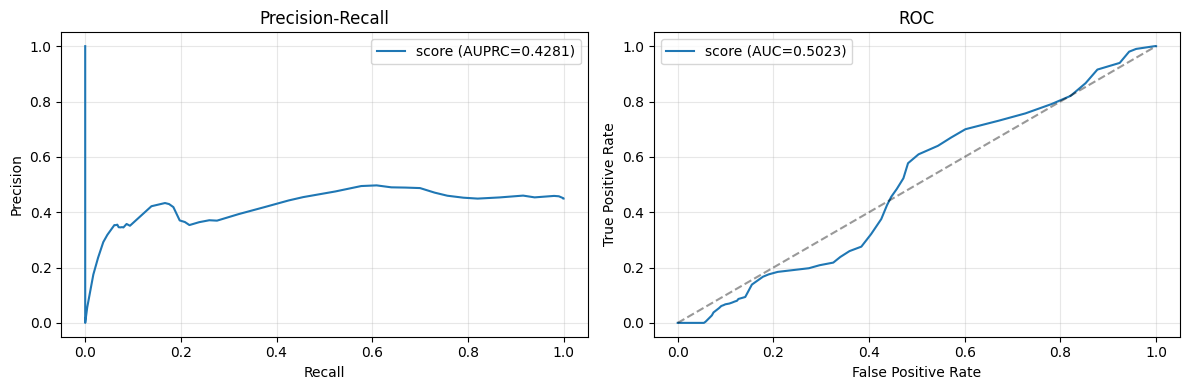

In [ ]:

# Curve possono stare in <run>/curves (vecchi run) o <run>/preds/curves (run recenti)
curves_candidates = [
    out_path / Path('curves'),
    out_path / Path('preds') / Path('curves'),
]
CURVES_DIR = next((p for p in curves_candidates if p.exists()), None)
if CURVES_DIR is None:
    raise FileNotFoundError(f"Curve PR/ROC non trovate in: {curves_candidates}. Assicurati di aver passato --sweep-curves.")

pr_path = CURVES_DIR / 'pr_curve_combined.csv'
roc_path = CURVES_DIR / 'roc_curve_combined.csv'
if not (pr_path.exists() and roc_path.exists()):
    raise FileNotFoundError(f"Missing curve files: {pr_path} / {roc_path}")

pr_df = pd.read_csv(pr_path)
roc_df = pd.read_csv(roc_path)

# Threshold sweep (τ) per scegliere un punto operativo migliore (es. massimizza F1).
if {'precision', 'recall', 'threshold'}.issubset(pr_df.columns):
    eps = 1e-12
    f1 = 2 * pr_df['precision'] * pr_df['recall'] / (pr_df['precision'] + pr_df['recall'] + eps)
    best_idx = int(f1.idxmax())
    best_row = pr_df.loc[best_idx]
    tau_best = float(best_row['threshold'])
    summary_tau = pd.DataFrame([{
        'τ_best(F1)': tau_best,
        'Precision@τ_best': float(best_row['precision']),
        'Recall@τ_best': float(best_row['recall']),
        'F1@τ_best': float(f1.loc[best_idx]),
        'τ_attuale': tau_used,
    }])
    display(summary_tau)
    print(f"Suggerimento: rilancia inferenza con --peak-threshold {tau_best:.3f} (oppure --threshold se non usi peak).")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# PR
ap = pr_df['pr_auc'].dropna().iloc[0] if 'pr_auc' in pr_df else None
axes[0].plot(pr_df['recall'], pr_df['precision'], label=f'score (AUPRC={ap:.4f})' if ap is not None else 'score')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# ROC
auc = roc_df['roc_auc'].dropna().iloc[0] if 'roc_auc' in roc_df else None
axes[1].plot(roc_df['fpr'], roc_df['tpr'], label=f'score (AUC={auc:.4f})' if auc is not None else 'score')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.4)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig(LOG_PATH.parent / 'precision-recall-ROC.png')
plt.show()


## View heatmap

In [32]:
# --- View predicted heatmap + clip animation (T dimension) ---
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display

import torch
import yaml


def find_repo_root(marker: str = "config/default.yml", max_depth: int = 6) -> Path:
    root = Path.cwd().resolve()
    for _ in range(max_depth):
        if (root / marker).exists():
            return root
        root = root.parent
    raise FileNotFoundError("config/default.yml non trovato; lancia il notebook dalla repo.")


REPO_ROOT = find_repo_root()
sys.path.insert(0, str(REPO_ROOT / "src"))

from cyclone_locator.datasets.med_fullbasin import MedFullBasinDataset
from cyclone_locator.utils.dsnt import spatial_softmax_2d, dsnt_expectation

# Reload moduli modello per evitare cache di definizioni vecchie nel kernel
import importlib
import cyclone_locator.models.simplebaseline as simplebaseline_mod
import cyclone_locator.models.x3d_backbone as x3d_mod
importlib.reload(simplebaseline_mod)
importlib.reload(x3d_mod)
SimpleBaseline = simplebaseline_mod.SimpleBaseline
X3DBackbone = x3d_mod.X3DBackbone


# 1) Config + checkpoint
cfg_default = yaml.safe_load(open(REPO_ROOT / "config/default.yml"))

# Scegli un checkpoint salvato da train.py (di default: best.ckpt)
ckpt_candidates = [
    out_path / "best.ckpt",
    out_path / "last.ckpt",
    out_path / "checkpoint.ckpt",
    out_path / "model.ckpt",
]
ckpt_path = next((p for p in ckpt_candidates if p.exists()), None)
if ckpt_path is None:
    raise FileNotFoundError(
        f"Nessun checkpoint trovato in {out_path}. "
        f"Imposta manualmente ckpt_path = Path('.../best.ckpt')."
    )

state = torch.load(ckpt_path, map_location="cpu")
cfg = state.get("cfg", cfg_default)
train_cfg = cfg.get("train", {})
data_cfg = cfg.get("data", {})
loss_cfg = cfg.get("loss", {})

cfg_source = "checkpoint" if isinstance(state, dict) and "cfg" in state else "config/default.yml"
if cfg_source != "checkpoint":
    print("[WARN] checkpoint senza cfg: uso config/default.yml (possibile mismatch config/checkpoint)")

def _warn_if_mismatch(key: str, default_val, ckpt_val):
    if default_val != ckpt_val:
        print(f"[WARN] cfg mismatch {key}: default={default_val} ckpt={ckpt_val}")

_warn_if_mismatch("train.backbone", cfg_default.get("train", {}).get("backbone"), train_cfg.get("backbone"))
_warn_if_mismatch("train.image_size", cfg_default.get("train", {}).get("image_size"), train_cfg.get("image_size"))
_warn_if_mismatch("train.heatmap_stride", cfg_default.get("train", {}).get("heatmap_stride"), train_cfg.get("heatmap_stride"))
_warn_if_mismatch("train.temporal_T", cfg_default.get("train", {}).get("temporal_T"), train_cfg.get("temporal_T"))
_warn_if_mismatch("train.temporal_stride", cfg_default.get("train", {}).get("temporal_stride"), train_cfg.get("temporal_stride"))
_warn_if_mismatch("train.presence_from_peak", cfg_default.get("train", {}).get("presence_from_peak"), train_cfg.get("presence_from_peak"))


# 2) Modello
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = train_cfg.get("backbone", "resnet18")
pretrained = bool(train_cfg.get("backbone_pretrained", True))
temporal_T = int(train_cfg.get("temporal_T", 1))

heatmap_stride = int(train_cfg.get("heatmap_stride", 4))

if str(backbone).startswith("x3d"):
    try:
        model = X3DBackbone(backbone=str(backbone), pretrained=pretrained, heatmap_stride=heatmap_stride)
    except ImportError as exc:
        raise ImportError(
            "Backbone x3d richiede pytorchvideo. Installa pytorchvideo oppure usa un backbone resnet.*"
        ) from exc
else:
    model = SimpleBaseline(backbone=str(backbone), temporal_T=temporal_T, pretrained=pretrained, heatmap_stride=heatmap_stride)

weights = state.get("model", state)
try:
    model.load_state_dict(weights, strict=True)
except RuntimeError as exc:
    print(f"[WARN] load_state_dict(strict=True) failed: {exc}")
    print("[WARN] Retrying with strict=False (solo per debug/visualizzazione; decoder potrebbe essere non coerente).")
    model.load_state_dict(weights, strict=False)
model.to(device).eval()


# 3) Dataset (val di default)
val_manifest_csv = REPO_ROOT / data_cfg.get("manifest_val", data_cfg.get("manifest_train"))
test_manifest_csv = REPO_ROOT / data_cfg.get("manifest_test", data_cfg.get("manifest_train"))
train_manifest_csv = REPO_ROOT / data_cfg.get("manifest_train", "")
meta_csv = REPO_ROOT / data_cfg.get("letterbox_meta_csv", "")

dataset = MedFullBasinDataset(
    csv_path=str(test_manifest_csv),
    image_size=int(train_cfg.get("image_size", 512)),
    heatmap_stride=int(train_cfg.get("heatmap_stride", 4)),
    heatmap_sigma_px=float(loss_cfg.get("heatmap_sigma_px", 8)),
    use_aug=False,
    use_pre_letterboxed=bool(data_cfg.get("use_pre_letterboxed", True)),
    letterbox_meta_csv=str(meta_csv) if str(meta_csv) else None,
    letterbox_size_assert=data_cfg.get("letterbox_size_assert"),
    temporal_T=int(train_cfg.get("temporal_T", 1)),
    temporal_stride=int(train_cfg.get("temporal_stride", 1)),
)


def show_pred_heatmap(sample_idx: int = 0, frame_t: int = 0):
    sample = dataset[int(sample_idx)]
    stride_cfg = int(train_cfg.get("heatmap_stride", 4))

    video = sample["video"].unsqueeze(0).to(device)
    image = sample["image"].unsqueeze(0).to(device)
    inp = video if getattr(model, "input_is_video", False) else image

    with torch.no_grad():
        hm_pred, presence_logit = model(inp)

    hm_pred = hm_pred.squeeze(0).squeeze(0)
    hm_pred_vis = torch.sigmoid(hm_pred).cpu().numpy()
    hm_tgt = sample["heatmap"].squeeze(0).squeeze(0).cpu().numpy()

    presence_gt = float(sample["presence"].item())

    infer_cfg = cfg.get("infer", {})
    use_peak = bool(train_cfg.get("presence_from_peak", False) or infer_cfg.get("presence_from_peak", False))
    tau = float(infer_cfg.get("peak_threshold") if use_peak and infer_cfg.get("peak_threshold") is not None else infer_cfg.get("presence_threshold", 0.5))

    presence_head_prob = float(torch.sigmoid(presence_logit).item())
    peak_logit = float(hm_pred.max().item())
    peak_prob = float(torch.sigmoid(torch.tensor(peak_logit)).item())

    presence_prob = peak_prob if use_peak else presence_head_prob
    presence_from_peak_prob = peak_prob
    presence_from_peak_pred = int(peak_prob >= tau)
    presence_pred = int(presence_prob >= tau)

    # Derive stride from actual tensor shapes to avoid config/checkpoint mismatches
    frame_h = float(sample["video"].shape[2])
    stride_real = frame_h / float(hm_pred_vis.shape[0])
    if abs(stride_real - float(stride_cfg)) > 1e-6:
        print(f"[WARN] heatmap stride mismatch: cfg={stride_cfg} vs real={stride_real:.4f} (frame={int(frame_h)} hm={hm_pred_vis.shape[0]})")
    stride = stride_real

    ty, tx = np.unravel_index(np.argmax(hm_tgt), hm_tgt.shape)
    py, px = np.unravel_index(np.argmax(hm_pred_vis), hm_pred_vis.shape)
    tx_lb, ty_lb = (tx + 0.5) * stride, (ty + 0.5) * stride
    px_lb, py_lb = (px + 0.5) * stride, (py + 0.5) * stride

    frames = sample["video"].permute(1, 2, 3, 0).cpu().numpy()  # (T,H,W,C)
    t = int(np.clip(frame_t, 0, frames.shape[0] - 1))
    frame = np.clip(frames[t], 0.0, 1.0)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(frame)
    axes[0].scatter([tx_lb], [ty_lb], c="cyan", s=60, marker="x", label="target peak")
    axes[0].scatter([px_lb], [py_lb], c="lime", s=60, marker="x", label="pred peak")
    axes[0].set_title(
        f"idx={sample_idx} | t={t}/{frames.shape[0]-1} | presence_gt={presence_gt:.3f} | prob={presence_prob:.3f} pred={presence_pred} | peak_prob={presence_from_peak_prob:.3f} peak_pred={presence_from_peak_pred} | tau={tau:.2f} | head_prob={presence_head_prob:.3f}"
    )
    axes[0].axis("off")
    axes[0].legend(loc="lower left")

    hm_tgt_im = axes[1].imshow(hm_tgt, cmap="magma", vmin=0, vmax=1, interpolation="bilinear")
    axes[1].scatter([tx], [ty], c="cyan", s=60, marker="x", label="tgt argmax")
    axes[1].legend(loc="lower left")
    axes[1].set_title("Target heatmap")
    axes[1].axis("off")
    fig.colorbar(hm_tgt_im, ax=axes[1], fraction=0.046, pad=0.04)

    hm_pred_im = axes[2].imshow(hm_pred_vis, cmap="magma", vmin=0, vmax=1, interpolation="bilinear")
    axes[2].scatter([px], [py], c="lime", s=60, marker="x", label="pred argmax")
    axes[2].legend(loc="lower left")
    axes[2].set_title("Pred heatmap (sigmoid)")
    axes[2].axis("off")
    fig.colorbar(hm_pred_im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    save_path = out_path / f"debug_heatmap_sample_{int(sample_idx)}.png"
    plt.savefig(save_path, dpi=150)
    print(f"Saved: {save_path}")
    plt.show()


def show_pred_animation(
    sample_idx: int = 0,
    interval_ms: int = 200,
    repeat: bool = True,
    heatmap: str = "pred",  # "pred" | "target"
    save_first_frame: bool = True,
):
    sample = dataset[int(sample_idx)]
    stride_cfg = int(train_cfg.get("heatmap_stride", 4))

    video = sample["video"].unsqueeze(0).to(device)
    image = sample["image"].unsqueeze(0).to(device)
    inp = video if getattr(model, "input_is_video", False) else image

    with torch.no_grad():
        hm_pred, presence_logit = model(inp)

    hm_pred = hm_pred.squeeze(0).squeeze(0)
    hm_pred_vis = torch.sigmoid(hm_pred).cpu().numpy()
    hm_tgt = sample["heatmap"].squeeze(0).squeeze(0).cpu().numpy()

    presence_gt = float(sample["presence"].item())

    infer_cfg = cfg.get("infer", {})
    use_peak = bool(train_cfg.get("presence_from_peak", False) or infer_cfg.get("presence_from_peak", False))
    tau = float(infer_cfg.get("peak_threshold") if use_peak and infer_cfg.get("peak_threshold") is not None else infer_cfg.get("presence_threshold", 0.5))

    presence_head_prob = float(torch.sigmoid(presence_logit).item())
    peak_logit = float(hm_pred.max().item())
    peak_prob = float(torch.sigmoid(torch.tensor(peak_logit)).item())

    presence_prob = peak_prob if use_peak else presence_head_prob
    presence_from_peak_prob = peak_prob
    presence_from_peak_pred = int(peak_prob >= tau)
    presence_pred = int(presence_prob >= tau)

    # Derive stride from actual tensor shapes to avoid config/checkpoint mismatches
    frame_h = float(sample["video"].shape[2])
    stride_real = frame_h / float(hm_pred_vis.shape[0])
    if abs(stride_real - float(stride_cfg)) > 1e-6:
        print(f"[WARN] heatmap stride mismatch: cfg={stride_cfg} vs real={stride_real:.4f} (frame={int(frame_h)} hm={hm_pred_vis.shape[0]})")
    stride = stride_real

    ty, tx = np.unravel_index(np.argmax(hm_tgt), hm_tgt.shape)
    py, px = np.unravel_index(np.argmax(hm_pred_vis), hm_pred_vis.shape)
    tx_lb, ty_lb = (tx + 0.5) * stride, (ty + 0.5) * stride
    px_lb, py_lb = (px + 0.5) * stride, (py + 0.5) * stride

    frames = sample["video"].permute(1, 2, 3, 0).cpu().numpy()  # (T,H,W,C)
    T = int(frames.shape[0])

    center_abs = sample.get("image_path_abs")
    window_paths = dataset.temporal_selector.get_window(center_abs) if center_abs else None
    frame_names = [Path(p).name for p in window_paths] if window_paths else None

    hm_show = hm_pred_vis if heatmap == "pred" else hm_tgt
    hm_title = "Pred heatmap (sigmoid)" if heatmap == "pred" else "Target heatmap"

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    f0 = np.clip(frames[0], 0.0, 1.0)
    is_gray = (f0.ndim == 3 and f0.shape[2] == 1)
    if is_gray:
        frame_im = axes[0].imshow(f0[..., 0], cmap="gray", vmin=0, vmax=1)
    else:
        frame_im = axes[0].imshow(f0)

    axes[0].scatter([tx_lb], [ty_lb], c="lime", s=60, marker="x", label="target peak")
    axes[0].scatter([px_lb], [py_lb], c="red", s=60, marker="x", label="pred peak")
    name0 = frame_names[0] if frame_names else str(Path(sample.get("image_path", "")).name)
    axes[0].set_title(
        f"{name0} | idx={sample_idx} | t=0/{T-1} | presence_gt={presence_gt:.3f} | prob={presence_prob:.3f} pred={presence_pred} | peak_prob={presence_from_peak_prob:.3f} peak_pred={presence_from_peak_pred} | tau={tau:.2f} | head_prob={presence_head_prob:.3f}"
    )
    axes[0].axis("off")
    axes[0].legend(loc="lower left")

    hm_im = axes[1].imshow(hm_show, cmap="magma", vmin=0, vmax=1, interpolation="bilinear")
    # markers in heatmap coordinates
    axes[1].scatter([tx], [ty], c="cyan", s=60, marker="x", label="tgt argmax")
    axes[1].scatter([px], [py], c="lime", s=60, marker="x", label="pred argmax")
    axes[1].legend(loc="lower left")
    axes[1].set_title(hm_title)
    axes[1].axis("off")
    fig.colorbar(hm_im, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()

    if save_first_frame:
        save_path = out_path / f"debug_heatmap_anim_{int(sample_idx)}_t0.png"
        fig.savefig(save_path, dpi=150)
        print(f"Saved: {save_path}")

    # Debug numerico: argmax vs DSNT (spesso diverge se c'è un hot pixel)
    hm_pred_prob = torch.sigmoid(hm_pred)
    prob2d = spatial_softmax_2d(hm_pred.unsqueeze(0).unsqueeze(0), tau=float(train_cfg.get('dsnt_tau', 1.0) or 1.0))
    pred_xy_dsnt = dsnt_expectation(prob2d).squeeze(0).cpu().numpy()  # (x_hm,y_hm)
    pred_dsnt_lb = ((pred_xy_dsnt[0] + 0.5) * stride, (pred_xy_dsnt[1] + 0.5) * stride)
    tgt_sum = float(hm_tgt.sum())
    if tgt_sum > 0:
        yy, xx = np.mgrid[0:hm_tgt.shape[0], 0:hm_tgt.shape[1]]
        tgt_cx = float((hm_tgt * xx).sum() / tgt_sum)
        tgt_cy = float((hm_tgt * yy).sum() / tgt_sum)
        tgt_centroid_lb = ((tgt_cx + 0.5) * stride, (tgt_cy + 0.5) * stride)
    else:
        tgt_cx = tgt_cy = float('nan')
        tgt_centroid_lb = (float('nan'), float('nan'))

    print(f"stride={stride} hm_shape={hm_tgt.shape} pred_prob_range=[{hm_pred_vis.min():.4f},{hm_pred_vis.max():.4f}]")
    print(f"target argmax hm=(x={tx},y={ty}) lb=(x={tx_lb:.1f},y={ty_lb:.1f}) val={hm_tgt[ty,tx]:.3f}")
    print(f"target centroid hm=(x={tgt_cx:.2f},y={tgt_cy:.2f}) lb=(x={tgt_centroid_lb[0]:.1f},y={tgt_centroid_lb[1]:.1f})")
    print(f"pred argmax hm=(x={px},y={py}) lb=(x={px_lb:.1f},y={py_lb:.1f}) prob={hm_pred_vis[py,px]:.3f}")
    print(f"pred dsnt hm=(x={pred_xy_dsnt[0]:.2f},y={pred_xy_dsnt[1]:.2f}) lb=(x={pred_dsnt_lb[0]:.1f},y={pred_dsnt_lb[1]:.1f})")
    print(f"peak_logit={peak_logit:.3f} peak_prob(sigmoid)={peak_prob:.3f} tau={tau:.3f} presence_prob={presence_prob:.3f}")

    def update(t: int):
        f = np.clip(frames[t], 0.0, 1.0)
        if is_gray:
            frame_im.set_array(f[..., 0])
        else:
            frame_im.set_array(f)
        name = frame_names[t] if frame_names else str(Path(sample.get("image_path", "")).name)
        axes[0].set_title(
            f"{name} | idx={sample_idx} | t={t}/{T-1} | p_gt={presence_gt:.3f} | peak_prob={presence_from_peak_prob:.3f} peak_pred={presence_from_peak_pred}"
        )
        return (frame_im,)

    anim = animation.FuncAnimation(
        fig,
        update,
        frames=T,
        interval=int(interval_ms),
        blit=False,
        repeat=bool(repeat),
    )
    display(HTML(anim.to_jshtml()))
    plt.close(fig)


# Cambia sample_idx / frame_t a piacere
# show_pred_heatmap(sample_idx=3508, frame_t=0)
show_pred_animation(sample_idx=3881, interval_ms=200, repeat=True, heatmap="pred")


Saved: ../outputs/runs/exp_9_hm-upsample+conv_stride1/debug_heatmap_anim_3881_t0.png
stride=1.0 hm_shape=(224, 224) pred_prob_range=[0.0002,0.1197]
target argmax hm=(x=122,y=117) lb=(x=122.5,y=117.5) val=1.000
target centroid hm=(x=122.00,y=117.00) lb=(x=122.5,y=117.5)
pred argmax hm=(x=121,y=122) lb=(x=121.5,y=122.5) prob=0.120
pred dsnt hm=(x=119.24,y=121.66) lb=(x=119.7,y=122.2)
peak_logit=-1.995 peak_prob(sigmoid)=0.120 tau=0.400 presence_prob=0.120
